In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import konlpy
import sentencepiece as spm
import os
import pandas as pd

%matplotlib inline

print(tf.__version__)
print(np.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
0.5.2


## 전처리된 데이터 로딩

In [4]:
# file open
train_data = pd.read_csv('ratings_train_clean.txt')
test_data = pd.read_csv('ratings_test_clean.txt')

train_data.head()


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
test_data.head()

,id,document,label
0,6270596,굳,1
1,9274899,gdntopclassintheclub,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,d만 아니었어도 별 다섯 개 줬을텐데 왜 d로 나와서 제 심기를 불편하게 하죠,0


In [6]:
print("Train Data Size:", train_data.shape)
print("Test Data Size:", test_data.shape)

Train Data Size: (146182, 3)
Test Data Size: (49157, 3)


In [20]:
all_texts = pd.concat([train_data['document'], test_data['document']], ignore_index=True)
len(all_texts)
all_texts.head()

0                                    아 더빙 진짜 짜증나네요 목소리
1                         흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                           교도소 이야기구먼 솔직히 재미는 없다 평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...
Name: document, dtype: object

## 토큰화

**Vocab Size**
1. 말뭉치 크기
- 작은 말뭉치 (~수십만 문장) : 어휘 크기를 너무 크게 하면 과적합(overfitting)되기 쉽고, 희소한 토큰이 많아지므로, 2.000 ~ 8,000 권장 
- 중간규모 말뭉치 (수백만 문장 ) : 16,000 ~ 32,000
- 대규모 말뭉치 (수천만~수억)  : 32,000 ~ 64,000+

2. 한국어 
- 큰 어휘 집합이 더 효율적 

3. 텍스트 분류/감성 분석: 표현력보다는 특징의 일관성이 중요하므로 어휘 크기 작아도 무방

In [6]:
# SentencePiece 학습
input_file = 'ratings_clean.txt'
VOCAB_SIZE = 10000
seq_max_len =  60

# 모델 이름 prefix
model_prefix = 'nsmc_spm'
model_type = 'bpe'
# --model_type = unigram이 디폴트, bpe 옵션  (일반적을 bep가 감성 분석에 잘 맞음)

# 어휘 수, 문자 커버리지, 토크나이저 타입 등 설정
spm.SentencePieceTrainer.train(
    input=input_file,
    model_prefix=model_prefix,
    vocab_size=VOCAB_SIZE,
    model_type=model_type,             # bpe, unigram, char, word 중 선택 가능
    character_coverage=1.0,            # 한글: 1.0, 일본어: 0.9995, 영어: 1.0
    pad_id=0,                          # [PAD]
    unk_id=1,                          # [UNK]
    bos_id=2,                          # [BOS]
    eos_id=3,                          # [EOS]
    user_defined_symbols=[],           # 필요한 경우 특수토큰 직접 추가
    train_extremely_large_corpus=False  # (말뭉치가 10GB 이상일 때만 True)
)


sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ratings_clean.txt
  input_format: 
  model_prefix: nsmc_spm_8000
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_

In [7]:
sp = spm.SentencePieceProcessor()
#sp.load("nsmc_spm.model")
sp.load(f'{model_prefix}.model') 

text = "이 영화 진짜 재미 있어요!"
tokens = sp.encode(text, out_type=str)
print(tokens) 


['▁이', '▁영화', '▁진짜', '▁재미', '▁있어요', '!']


G(INFO) Added: freq=773 size=860 all=221150 active=14910 piece=▁추억
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=762 size=880 all=222690 active=16450 piece=▁개인적으로
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=744 size=900 all=223829 active=17589 piece=것이
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=743 min_freq=44
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=726 size=920 all=225507 active=12719 piece=▁당시
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=713 size=940 all=226996 active=14208 piece=놓고
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=697 size=960 all=228316 active=15528 piece=을듯
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=680 size=980 all=229628 active=16840 piece=▁점은
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=660 size=1000 all=230808 active=18020 piece=는게
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=660 min_freq=42
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=640 size=1020 all=232429 active=12992 piece=있고
b

In [8]:

def sp_vocabulary(model_prefix): 

    with open(f'{model_prefix}.vocab', 'r') as f:  #with open("./nsmc_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})
        
    return word_index, index_word

In [13]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        try:
            text = str(sen).strip()  # 문자열 강제 변환 및 공백 제거
            if text:  # 빈 문자열 제외
                tensor.append(s.EncodeAsIds(text))
        except Exception as e:
            print(f"오류 문장: {sen} / {e}")
            continue     
        
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=seq_max_len, padding='post')

    return tensor

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 어휘 사전 (index <-> word)
word_to_index, index_to_word = sp_vocabulary( model_prefix)

print("Vocab Size:", len(index_to_word))

# 문장을 ID 리스트로 변환
x_train = sp_tokenize( sp, train_data['document'] )
x_test = sp_tokenize( sp, test_data['document'] )

# 텐서로 변환 완료
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)



Vocab Size: 10000
x_train shape: (146182, 60)
x_test shape: (49157, 60)


In [11]:
from sklearn.model_selection import train_test_split


#x_label = train_data['label'].astype('float32').values
#X_train, X_val, y_train, y_val = train_test_split(x_train_padded, x_label, test_size=0.2, random_state=42)

X_train = x_train
y_train = x_test

X_val = train_data['label'].astype('float32').values
y_val = test_data['label'].astype('float32').values

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (146182, 60)
X_val shape: (146182,)
y_train shape: (49157, 60)
y_val shape: (49157,)


## 모델 구성 

In [12]:
word_vector_dim = 128  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(VOCAB_SIZE, word_vector_dim, input_length=seq_max_len))
model_lstm.add(tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(word_vector_dim) ))   
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 8)                 2056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,545,233
Trainable params: 1,545,233
Non-trainable params: 0
_________________________________________________________________


In [13]:
from tensorflow.keras.callbacks import EarlyStopping

model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20   
callbacks = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history_lstm = model_lstm.fit(
                    X_train, X_val,
                    validation_data=(y_train, y_val),
                    epochs=epochs,
                    batch_size=256,
                    verbose=1, 
                    callbacks = callbacks)

loss, acc = model_lstm.evaluate(y_train, y_val)
print(f" 최종 검증 정확도: {acc:.4f}")
print(f" 최종 검증 loss: {loss:.4f}")

Epoch 1/20
572/572 [==============================] - 15s 18ms/step - loss: 0.4015 - accuracy: 0.8134 - val_loss: 0.3476 - val_accuracy: 0.8456
Epoch 2/20
572/572 [==============================] - 10s 17ms/step - loss: 0.3118 - accuracy: 0.8643 - val_loss: 0.3334 - val_accuracy: 0.8528
Epoch 3/20
572/572 [==============================] - 10s 17ms/step - loss: 0.2760 - accuracy: 0.8810 - val_loss: 0.3336 - val_accuracy: 0.8524
Epoch 4/20
572/572 [==============================] - 10s 17ms/step - loss: 0.2455 - accuracy: 0.8948 - val_loss: 0.3539 - val_accuracy: 0.8509
Epoch 5/20
572/572 [==============================] - 10s 17ms/step - loss: 0.2173 - accuracy: 0.9101 - val_loss: 0.3697 - val_accuracy: 0.8491
Epoch 00005: early stopping
1537/1537 [==============================] - 6s 4ms/step - loss: 0.3697 - accuracy: 0.8491
 최종 검증 정확도: 0.8491
 최종 검증 loss: 0.3697


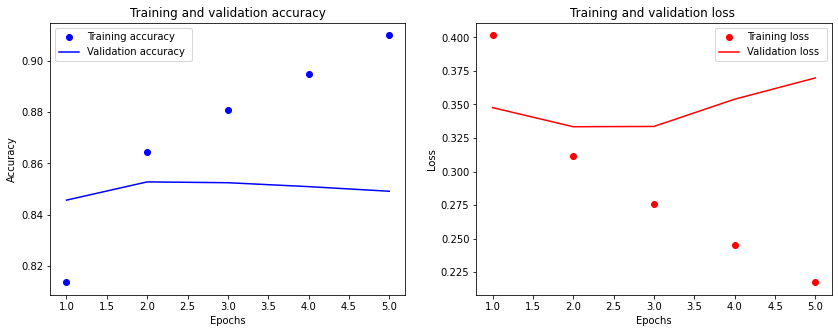

In [14]:
# 시각화

import matplotlib.pyplot as plt

history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy ')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training loss ')
plt.plot(epochs, val_loss, 'r', label='Validation loss ')
plt.title('Training and validation loss ')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

## VOCAB_SIZE별 시험

In [10]:
seq_max_len =  60
input_file = 'ratings_clean.txt'

results = []

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

def sentencepiece_vocab_test(vocab_size, model_type = 'unigram') : 

    print(f"\n============================")
    print(f"✅ vocab_size = {vocab_size}")
    print(f"============================")
    
    # SentencePiece 학습
    # 모델 이름 prefix
    model_prefix = f'nsmc_spm_{vocab_size}'
    #model_type = 'bpe'
    # --model_type = unigram이 디폴트, bpe 옵션  (일반적을 bep가 감성 분석에 잘 맞음)

    # 어휘 수, 문자 커버리지, 토크나이저 타입 등 설정
    spm.SentencePieceTrainer.train(
        input=input_file,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        model_type=model_type,             # bpe, unigram, char, word 중 선택 가능
        character_coverage=1.0,            # 한글: 1.0, 일본어: 0.9995, 영어: 1.0
        pad_id=0,                          # [PAD]
        unk_id=1,                          # [UNK]
        bos_id=2,                          # [BOS]
        eos_id=3,                          # [EOS]
        user_defined_symbols=[],           # 필요한 경우 특수토큰 직접 추가
        train_extremely_large_corpus=False  # (말뭉치가 10GB 이상일 때만 True)
    )
    
    # SentencePiece 로딩
    sp = spm.SentencePieceProcessor()
    sp.load(f'{model_prefix}.model') 
  
    # 어휘 사전 (index <-> word)
    word_to_index, index_to_word = sp_vocabulary(model_prefix)
    print("Vocab Size:", len(index_to_word))

    # 문장을 ID 리스트로 변환
    X_train = sp_tokenize( sp, train_data['document'] )
    y_train = sp_tokenize( sp, test_data['document'] )
    
    X_val = train_data['label'].astype('float32').values
    y_val = test_data['label'].astype('float32').values
    
    # 모델 구성    
    word_vector_dim = 128  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

    # model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=seq_max_len))
    model.add(tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(word_vector_dim) ))   
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.    
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # 훈련
    epochs=20   
    callbacks = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

    history = model.fit(
                    X_train, X_val,
                    validation_data=(y_train, y_val),
                    epochs=epochs,
                    batch_size=256,
                    verbose=1, 
                    callbacks = callbacks)

    loss, acc = model.evaluate(y_train, y_val)
    print(f" 최종 검증 정확도: {acc:.4f}")
    print(f" 최종 검증 loss: {loss:.4f}")
    
    # 결과 저장
    best_epoch = len(history.history['val_loss'])
    results.append({
        'vocab_size': vocab_size, 
        'best_epoch': best_epoch, 
        'val_accuracy': acc
        })    
    



In [16]:
# for vocab_size in [4000, 6000, 8000, 10000]:
sentencepiece_vocab_test( 6000, model_type = 'bpe')


✅ vocab_size = 6000
Vocab Size: 6000
Epoch 1/20
572/572 [==============================] - 14s 17ms/step - loss: 0.4144 - accuracy: 0.8051 - val_loss: 0.3623 - val_accuracy: 0.8399
Epoch 2/20
572/572 [==============================] - 9s 16ms/step - loss: 0.3360 - accuracy: 0.8519 - val_loss: 0.3549 - val_accuracy: 0.8438
Epoch 3/20
572/572 [==============================] - 9s 16ms/step - loss: 0.3086 - accuracy: 0.8644 - val_loss: 0.3482 - val_accuracy: 0.8466
Epoch 4/20
572/572 [==============================] - 9s 16ms/step - loss: 0.2863 - accuracy: 0.8753 - val_loss: 0.3613 - val_accuracy: 0.8483
Epoch 5/20
572/572 [==============================] - 10s 17ms/step - loss: 0.2656 - accuracy: 0.8859 - val_loss: 0.3446 - val_accuracy: 0.8494
Epoch 6/20
572/572 [==============================] - 10s 17ms/step - loss: 0.2448 - accuracy: 0.8967 - val_loss: 0.3600 - val_accuracy: 0.8463
Epoch 7/20
572/572 [==============================] - 10s 17ms/step - loss: 0.2213 - accuracy: 0.9086

In [19]:
sentencepiece_vocab_test( 4000, model_type = 'bpe')


✅ vocab_size = 4000
Vocab Size: 4000
Epoch 1/20
572/572 [==============================] - 12s 17ms/step - loss: 0.4287 - accuracy: 0.7947 - val_loss: 0.3820 - val_accuracy: 0.8241
Epoch 2/20
572/572 [==============================] - 9s 17ms/step - loss: 0.3548 - accuracy: 0.8391 - val_loss: 0.3658 - val_accuracy: 0.8332
Epoch 3/20
572/572 [==============================] - 10s 17ms/step - loss: 0.3281 - accuracy: 0.8528 - val_loss: 0.3495 - val_accuracy: 0.8411
Epoch 4/20
572/572 [==============================] - 10s 17ms/step - loss: 0.3081 - accuracy: 0.8642 - val_loss: 0.3510 - val_accuracy: 0.8414
Epoch 5/20
572/572 [==============================] - 10s 17ms/step - loss: 0.2904 - accuracy: 0.8738 - val_loss: 0.3467 - val_accuracy: 0.8466
Epoch 6/20
572/572 [==============================] - 10s 17ms/step - loss: 0.2738 - accuracy: 0.8821 - val_loss: 0.3499 - val_accuracy: 0.8479
Epoch 7/20
572/572 [==============================] - 9s 17ms/step - loss: 0.2572 - accuracy: 0.890

In [20]:
sentencepiece_vocab_test( 8000, model_type = 'bpe')


✅ vocab_size = 8000
Vocab Size: 8000
Epoch 1/20
572/572 [==============================] - 12s 18ms/step - loss: 0.4160 - accuracy: 0.8054 - val_loss: 0.3561 - val_accuracy: 0.8424
Epoch 2/20
572/572 [==============================] - 10s 17ms/step - loss: 0.3275 - accuracy: 0.8563 - val_loss: 0.3532 - val_accuracy: 0.8478
Epoch 3/20
572/572 [==============================] - 10s 17ms/step - loss: 0.2999 - accuracy: 0.8691 - val_loss: 0.3390 - val_accuracy: 0.8491
Epoch 4/20
572/572 [==============================] - 10s 17ms/step - loss: 0.2751 - accuracy: 0.8814 - val_loss: 0.3506 - val_accuracy: 0.8481
Epoch 5/20
572/572 [==============================] - 10s 17ms/step - loss: 0.2509 - accuracy: 0.8928 - val_loss: 0.3554 - val_accuracy: 0.8497
Epoch 6/20
572/572 [==============================] - 10s 17ms/step - loss: 0.2230 - accuracy: 0.9058 - val_loss: 0.3975 - val_accuracy: 0.8479
Epoch 00006: early stopping
1537/1537 [==============================] - 6s 4ms/step - loss: 0.397

In [21]:
sentencepiece_vocab_test( 4000, model_type = 'char')


✅ vocab_size = 4000
Vocab Size: 2683
Epoch 1/20
572/572 [==============================] - 12s 18ms/step - loss: 0.4854 - accuracy: 0.7603 - val_loss: 0.4357 - val_accuracy: 0.7970
Epoch 2/20
572/572 [==============================] - 9s 16ms/step - loss: 0.4079 - accuracy: 0.8106 - val_loss: 0.4071 - val_accuracy: 0.8123
Epoch 3/20
572/572 [==============================] - 10s 17ms/step - loss: 0.3789 - accuracy: 0.8262 - val_loss: 0.3918 - val_accuracy: 0.8187
Epoch 4/20
572/572 [==============================] - 10s 17ms/step - loss: 0.3596 - accuracy: 0.8376 - val_loss: 0.3780 - val_accuracy: 0.8272
Epoch 5/20
572/572 [==============================] - 10s 17ms/step - loss: 0.3435 - accuracy: 0.8464 - val_loss: 0.3821 - val_accuracy: 0.8203
Epoch 6/20
572/572 [==============================] - 10s 17ms/step - loss: 0.3299 - accuracy: 0.8545 - val_loss: 0.3745 - val_accuracy: 0.8305
Epoch 7/20
572/572 [==============================] - 10s 17ms/step - loss: 0.3178 - accuracy: 0.86

In [22]:
# 결과 정리
results_df = pd.DataFrame(results)
print(results_df)

   vocab_size  best_epoch  val_accuracy
0        6000           8      0.838924
1        4000           8      0.842077
2        8000           6      0.847936
3        4000          12      0.841467


## 회고

 **vocab_size별 Test 결과** 
 - VOCAB = 10000, seq_max_len = 60, type = bpe
     -  최종 검증 정확도: 0.8491
     - 최종 검증 loss: 0.3697
     
 - VOCAB = 8000, seq_max_len = 60, type = bpe
     - 최종 검증 정확도: 0.8497
     - 최종 검증 loss: 0.3854
 
 - VOCAB = 6000, seq_max_len = 60, type = bpe
     - 최종 검증 정확도: 0.8479
     - 최종 검증 loss: 0.3868
     
 - VOCAB = 4000, seq_max_len = 60, type = bpe
     - 최종 검증 정확도: 0.8468
     - 최종 검증 loss: 0.3666

In [ ]:
**model_type**
 - type = char인 경우 vocab size가 줄어든다